# Bayesian model: Loan Prediction Problem

Use Bayesian methods to predict the probability that a loan application will be approved. Bayesian statistics can provide posterior probabilities, which are useful for decision-making under uncertainty. This would let you model the probability of loan approval conditioned on various factors, incorporating prior knowledge, such as general trends in credit history.

#### Data Download from Kaggle

In [5]:
import os
import zipfile
import pandas as pd
import shutil

In [6]:
# Step 1: Define the dataset download path
dataset_directory = "/Users/amit/Documents/kaggle-dataset/bayesian/"

# Step 2: Create the directory if it doesn't exist
os.makedirs(dataset_directory, exist_ok=True)

# Step 3: Download the dataset
# Make sure you have the Kaggle API key configured correctly
!kaggle datasets download altruistdelhite04/loan-prediction-problem-dataset -p "{dataset_directory}"

# Step 4: Unzip the downloaded dataset
zip_file_path = os.path.join(dataset_directory, "loan-prediction-problem-dataset.zip")  # Adjust the filename if necessary
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_directory)

# Step 5: Load the data into a DataFrame
# Check the contents of the directory to find the CSV file
extracted_files = os.listdir(dataset_directory)
print("Extracted files:", extracted_files)

Dataset URL: https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset
License(s): unknown
loan-prediction-problem-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracted files: ['train_u6lujuX_CVtuZ9i.csv', 'test_Y3wMUE5_7gLdaTN.csv', 'loan-prediction-problem-dataset.zip']


In [7]:
# Load the train data
csv_file = os.path.join(dataset_directory, 'train_u6lujuX_CVtuZ9i.csv')  # Adjust based on the extracted file names
train_data = pd.read_csv(csv_file)

### Data preprocessing

In [9]:
# Display the first few rows of the DataFrame
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Loan_Status is the target variable

In [11]:
# Get basic information about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [12]:
train_data['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

### Handling the missing values

- Gender: 13 missing values ; fill them with a placeholder like "Unknown".
- Married: 3 missing values ; fill them with a "No" assuming not married.
- Dependents: 15 missing values ; fill them with a placeholder like "0"
- Self_Employed: 32 missing values ; fill them with a "No" assuming not self employed.
- LoanAmount: 22 missing values ; fill them with a median value
- Loan_Amount_Term: 14 missing values ; fill them with a mode value
- Credit_History: 50 missing values ; Fill missing values with 1 (assuming good credit history for modeling).

In [15]:
# Step 1: Handle missing values
# Fill missing values in Gender, Married, Dependents, Self_Employed
train_data['Gender'] = train_data['Gender'].fillna('Unknown')
train_data['Married'] = train_data['Married'].fillna('No')
train_data['Dependents'] = train_data['Dependents'].fillna('0')
train_data['Self_Employed'] = train_data['Self_Employed'].fillna('No')

# Fill missing values in LoanAmount and Loan_Amount_Term
train_data['LoanAmount'] = train_data['LoanAmount'].fillna(train_data['LoanAmount'].median())
train_data['Loan_Amount_Term'] = train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].median())

# Fill missing values in Credit_History
train_data['Credit_History'] = train_data['Credit_History'].fillna(1.0)

# Verify that there are no more missing values
print(train_data.isnull().sum())

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


### Encode Categorical Variables

In [17]:
# Step 2: Encode categorical variables
train_data_encoded = pd.get_dummies(train_data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# Prepare the target variable
train_data_encoded['Loan_Status'] = train_data_encoded['Loan_Status'].map({'Y': 1, 'N': 0})  # Convert 'Y'/'N' to 1/0

# Check the preprocessed data
print(train_data_encoded.head())

    Loan_ID  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0  LP001002             5849                0.0       128.0             360.0   
1  LP001003             4583             1508.0       128.0             360.0   
2  LP001005             3000                0.0        66.0             360.0   
3  LP001006             2583             2358.0       120.0             360.0   
4  LP001008             6000                0.0       141.0             360.0   

   Credit_History  Loan_Status  Gender_Male  Gender_Unknown  Married_Yes  \
0             1.0            1         True           False        False   
1             1.0            0         True           False         True   
2             1.0            1         True           False         True   
3             1.0            1         True           False         True   
4             1.0            1         True           False        False   

   Dependents_1  Dependents_2  Dependents_3+  Education_

### Description Statistics

In [19]:
# Step 1: Drop the Loan_Status column for descriptive statistics
train_data_encoded_without_target = train_data_encoded.drop(columns=['Loan_Status'])

# Step 2: Get the descriptive statistics
descriptive_stats = train_data_encoded_without_target.describe()

# Step 3: Display the statistics
print(descriptive_stats)

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  614.000000        614.000000   
mean       5403.459283        1621.245798  145.752443        342.410423   
std        6109.041673        2926.248369   84.107233         64.428629   
min         150.000000           0.000000    9.000000         12.000000   
25%        2877.500000           0.000000  100.250000        360.000000   
50%        3812.500000        1188.500000  128.000000        360.000000   
75%        5795.000000        2297.250000  164.750000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  
count      614.000000  
mean         0.855049  
std          0.352339  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


### Feature Engineering

In [21]:
import numpy as np
#represent total household income
train_data_encoded['TotalIncome'] = train_data_encoded['ApplicantIncome'] + train_data_encoded['CoapplicantIncome']

#debt_to_income_ratio
train_data_encoded['debt_to_income_ratio'] = (train_data_encoded['LoanAmount']) / train_data_encoded['TotalIncome']

# Applying log transformation to reduce skewness
train_data_encoded['Log_ApplicantIncome'] = np.log1p(train_data_encoded['ApplicantIncome'])  # log1p is used to handle zero values
train_data_encoded['Log_CoapplicantIncome'] = np.log1p(train_data_encoded['CoapplicantIncome'])
train_data_encoded['Log_LoanAmount'] = np.log1p(train_data_encoded['LoanAmount'])

# Drop the original columns if the log-transformed versions will replace them in modeling
train_data_encoded = train_data_encoded.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','TotalIncome'], axis=1)

### Prepare Your Data for model building

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN  # or SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Select features and target variable
X = train_data_encoded.drop(columns=['Loan_ID', 'Loan_Status'])  # Drop Loan_ID and Loan_Status from features
y = train_data_encoded['Loan_Status']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure stratification based on target variable
)

# Check the shape of the resulting datasets
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (491, 16), y_train shape: (491,)
X_test shape: (123, 16), y_test shape: (123,)


### SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic examples for the minority class

In [26]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Fit the model using Gaussian Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# Initialize the Gaussian Naive Bayes model
model = GaussianNB()

# Fit the model to the training data
model.fit(X_train_resampled, y_train_resampled)

GaussianNB()

### Make predictions

In [30]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

# Predict binary outcomes based on a threshold
threshold = 0.5
y_pred_binary = (y_pred_proba >= threshold).astype(int)  # Convert probabilities to binary predictions

### Evaluate the model

In [32]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



### Visualize the Results

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

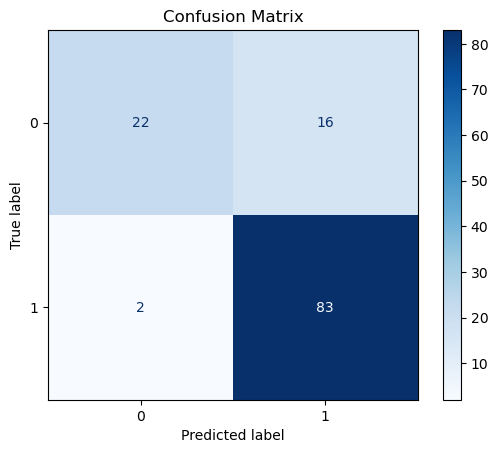

In [35]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # 0 = Loan Denied, 1 = Loan Approved
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()